In [1]:
import numpy as np
from matplotlib import pyplot as plt
import skimage.transform as skimt
import time
import scipy.sparse as sp
import copy

import pyxu.operator as pyxop
import os
import src.tomo_fusion.tools.helpers as tomo_helps
import src.tomo_fusion.tools.plotting_fcts as tomo_plots
import src.tomo_fusion.bayesian_computations as bcomp
import src.tomo_fusion.functionals_definition as fct_def
import src.tomo_fusion.hyperparameter_tuning as hyper_tune

/home/dhamm/miniconda3/envs/bayes-plasma-tomo/lib/python3.12/site-packages/cupy/_environment.py:540: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy-cuda11x, cupy-cuda12x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''
/home/dhamm/miniconda3/envs/bayes-plasma-tomo/lib/python3.12/site-packages/pyxu/info/plug

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def postprocess_uq_data(uq_data_dir):
    # Load phantom data
    psis = np.load('../dataset_generation/sxr_samples/psis.npy')
    sxr_samples = np.load('../dataset_generation/sxr_samples/sxr_samples_with_background.npy')
    trim_val = np.load('../dataset_generation/sxr_samples/trimming_values.npy')

    # pixel value stats
    pixels_within_quantiles = np.zeros((900, 5))
    pixels_within_n_stds = np.zeros((900, 3))
    mse_map, mse_mean = np.zeros(900), np.zeros(900)
    mse_map_core, mse_mean_core = np.zeros(900), np.zeros(900)
    mape_map, mape_mean = np.zeros(900), np.zeros(900)
    # peak location stats
    true_peak_loc = np.zeros((900, 2))
    peak_within_n_stds = np.zeros((900, 3))
    peak_distance_from_mean = np.zeros((900, 2))
    # prad stats
    true_prad_core = np.zeros(900)
    prad_within_n_stds = np.zeros((900, 3))
    prad_std_values = np.zeros(900)
    prad_rel_error_map, prad_rel_error_mean = np.zeros(900), np.zeros(900)
    prad_within_quantiles = np.zeros((900, 5))

    for idx in range(900):
        recon_shape = (120, 40)

        uq_data_idx = np.load(uq_data_dir + '/uq_data_' + str(idx) + '.npy', allow_pickle=True).item()
        quantile_marks = uq_data_idx['quantile_marks']

        ground_truth = sxr_samples[idx, :, :].squeeze()
        psi = psis[idx, :, :]

        mask_core = tomo_helps.define_core_mask(psi=psi, dim_shape=recon_shape, trim_values_x=trim_val[idx, :])

        # compute pixels withing quantile bounds stats
        ground_truth_downsampled = skimt.resize(ground_truth, uq_data_idx["im_MAP"].shape, anti_aliasing=False,
                                                mode='edge')  # * mask_core
        core_pixels_number = ground_truth_downsampled[ground_truth_downsampled > 1e-3].size
        for j in range(5):
            # quantile-related
            idxs = np.where((ground_truth_downsampled >= uq_data_idx["empirical_quantiles"][j, :, :]) & (
                        ground_truth_downsampled <= uq_data_idx["empirical_quantiles"][-(j + 1), :, :]))
            frac_pixels_within_quantiles_core = (idxs[0].size - (4800 - np.sum(mask_core))) / np.sum(mask_core)
            pixels_within_quantiles[idx, j] = frac_pixels_within_quantiles_core
        for j, nb_stds in enumerate(np.arange(1, 4)):
            # standard deviation-related
            pixels_within_n_stds_idxs = np.where((ground_truth_downsampled >= (uq_data_idx["mean"] - nb_stds * np.sqrt(uq_data_idx["var"]))) &
                                    (ground_truth_downsampled <= (uq_data_idx["mean"] + nb_stds * np.sqrt(uq_data_idx["var"]))))
            frac_pixels_within_n_stds_core = (pixels_within_n_stds_idxs[0].size - (4800 - core_pixels_number)) / core_pixels_number
            # frac_pixels_within_one_std_core = (idxs_one_std[0].size - (4800-np.sum(mask_core))) / np.sum(mask_core)
            pixels_within_n_stds[idx, j] = frac_pixels_within_n_stds_core
        mse_map[idx] = np.mean((ground_truth_downsampled - uq_data_idx["im_MAP"]) ** 2)
        mse_mean[idx] = np.mean((ground_truth_downsampled - uq_data_idx["mean"]) ** 2)
        mse_map_core[idx] = np.mean((ground_truth_downsampled[mask_core] - uq_data_idx["im_MAP"][mask_core]) ** 2)
        mse_mean_core[idx] = np.mean((ground_truth_downsampled[mask_core] - uq_data_idx["mean"][mask_core]) ** 2)
        mape_map[idx] = np.mean(np.abs((ground_truth_downsampled[mask_core] - uq_data_idx["im_MAP"][mask_core]) / ground_truth_downsampled[mask_core]))
        mape_mean[idx] = np.mean(np.abs((ground_truth_downsampled[mask_core] - uq_data_idx["mean"][mask_core])/ground_truth_downsampled[mask_core]))

        # compute peak location stats
        true_peak_loc[idx, :] = np.array(np.where(ground_truth == ground_truth.max())).reshape(2) / 2
        peak_distance_from_mean[idx, :] = (uq_data_idx["mean_peak_loc"] - true_peak_loc[idx, :]) * uq_data_idx["sampling"][0]
        for j, nb_stds in enumerate(np.arange(1, 4)):
            peak_within_n_stds[idx, j] = (
                    (np.abs(uq_data_idx["mean_peak_loc"][0] - true_peak_loc[idx, 0]) < nb_stds * np.sqrt(uq_data_idx["var_peak_loc"][0]))
                    and
                    (np.abs(uq_data_idx["mean_peak_loc"][1] - true_peak_loc[idx, 1]) < nb_stds * np.sqrt(uq_data_idx["var_peak_loc"][1])))

        # compute prad stats
        true_prad_core[idx] = tomo_helps.compute_radiated_power(ground_truth_downsampled, mask_core, uq_data_idx["sampling"])
        for j, nb_stds in enumerate(np.arange(1, 4)):
            prad_within_n_stds[idx, j] = np.abs(uq_data_idx["mean_prad_core"] - true_prad_core[idx]) < nb_stds * np.sqrt(uq_data_idx["var_prad_core"])
            #prad_within_n_stds[idx, j] = (uq_data_idx["mean_prad_core"] - true_prad_core) / np.sqrt(uq_data_idx["var_prad_core"])
        prad_std_values[idx] = np.sqrt(uq_data_idx["var_prad_core"])
        prad_rel_error_mean[idx] = (uq_data_idx["mean_prad_core"] - true_prad_core[idx]) / true_prad_core[idx]
        prad_rel_error_map[idx] = (uq_data_idx["prad_map_core"] - true_prad_core[idx]) / true_prad_core[idx]
        for j in range(5):
            prad_within_quantiles[idx, j] = (
                    (np.quantile(uq_data_idx["prads_core"], quantile_marks[-(j + 1)]) > true_prad_core[idx])
                    and
                    (np.quantile(uq_data_idx["prads_core"], quantile_marks[j]) < true_prad_core[idx])
            )
        postprocessed_uq_data = {"pixels_within_quantiles": pixels_within_quantiles, "pixels_within_n_stds": pixels_within_n_stds, "mse_map": mse_map,
                              "mse_mean": mse_mean, "mse_map_core": mse_map_core,
                              "mse_mean_core": mse_mean_core, "mape_map": mape_map, "mape_mean": mape_mean,
                              "true_peak_loc": true_peak_loc, "peak_within_n_stds": peak_within_n_stds, "peak_distance_from_mean": peak_distance_from_mean,
                              "true_prad_core": true_prad_core, "prad_within_n_stds": prad_within_n_stds, "prad_std_values": prad_std_values,
                              "prad_rel_error_map": prad_rel_error_map, "prad_rel_error_mean": prad_rel_error_mean, "prad_within_quantiles": prad_within_quantiles,
                              "quantile_marks": quantile_marks}
        np.save(uq_data_dir + "/postprocessed_data.npy", postprocessed_uq_data)

In [4]:
results_dirs = ["uq_study_results/sigma005", "uq_study_results/sigma01", "uq_study_results/sigma005005"]

In [13]:
for res_dir in results_dirs:
    postprocess_uq_data(res_dir)

/tmp/ipykernel_9036/1874917806.py:71: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prad_within_n_stds[idx, j] = np.abs(uq_data_idx["mean_prad_core"] - true_prad_core[idx]) < nb_stds * np.sqrt(uq_data_idx["var_prad_core"])
/tmp/ipykernel_9036/1874917806.py:73: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prad_std_values[idx] = np.sqrt(uq_data_idx["var_prad_core"])
/tmp/ipykernel_9036/1874917806.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prad_rel_error_me

In [14]:
aggregate_data = []

for res_dir in results_dirs:
    if not os.path.isfile(res_dir + "/postprocessed_data.npy"):
        postprocess_uq_data(res_dir)
    aggregate_data.append(np.load(res_dir + "/postprocessed_data.npy", allow_pickle=True).item())

In [15]:
aggregate_data[0].keys()

dict_keys(['pixels_within_quantiles', 'pixels_within_n_stds', 'mse_map', 'mse_mean', 'mse_map_core', 'mse_mean_core', 'mape_map', 'mape_mean', 'true_peak_loc', 'peak_within_n_stds', 'peak_distance_from_mean', 'true_prad_core', 'prad_within_n_stds', 'prad_std_values', 'prad_rel_error_map', 'prad_rel_error_mean', 'prad_within_quantiles', 'quantile_marks'])

# Analyze aggregate results

### Pixel value

First, we analyze whether appropriate bounds are computed for the individual pixel values.

In [16]:
noise_levels = [r"$\sigma=7\cdot 10^{-3}$", r"$\sigma=1.4\cdot 10^{-2}$", r"$\sigma_{LoS}=7\cdot 10^{-3} + 0.05\cdot y_{LoS}$"]
quantile_credible_intervals = [round(100*(aggregate_data[0]["quantile_marks"][-(j+1)] - aggregate_data[0]["quantile_marks"][j])) for j in range(4)]
nb_stds = [r"", r"$2$", r"$3$"]

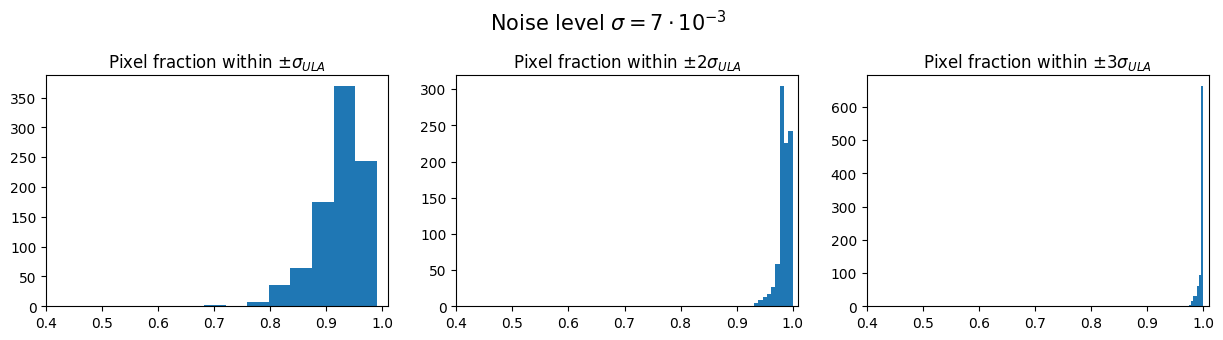

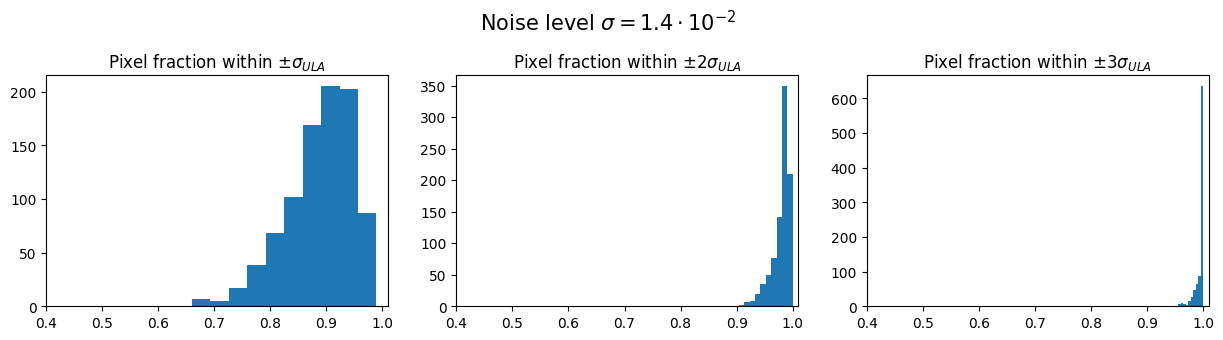

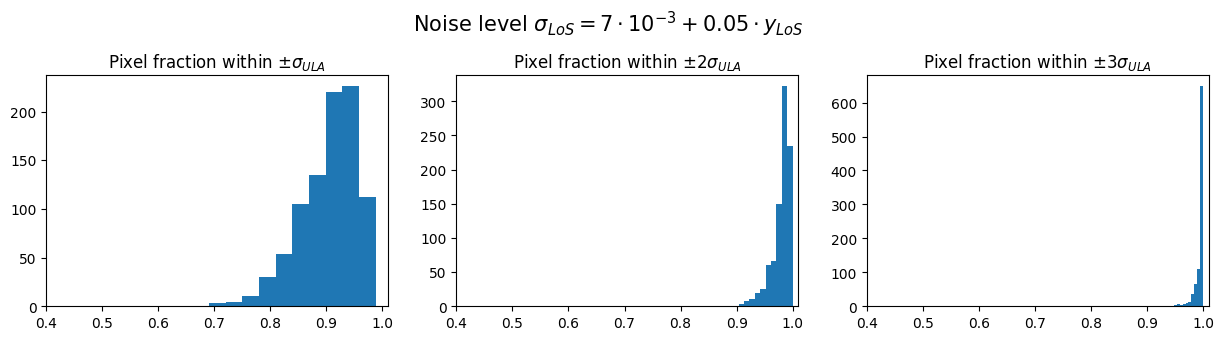

In [18]:
for i, noise_level in enumerate(noise_levels):
    fig, ax = plt.subplots(1,3, figsize=(15,3))
    for j, nb_stds in enumerate(np.arange(1,4)):
        ax[j].hist(aggregate_data[i]["pixels_within_n_stds"][:,j], bins=10, density=False)
        ax[j].set_xlim([0.4,1.01])
        if j == 0:
            ax[j].set_title(r"Pixel fraction within $\pm\sigma_{ULA}$")
        else:
            ax[j].set_title(r"Pixel fraction within $\pm$" + str(nb_stds) + r"$\sigma_{ULA}$")
    plt.suptitle("Noise level " + noise_level, y=1.1, fontsize=15)
    plt.show()

In [19]:
for i, noise_level in enumerate(noise_levels):
    print("Noise level " + noise_levels[i])
    print("Average (across phantoms) percentage of pixels falling within one standard deviation from the mean ",
          np.mean(aggregate_data[i]["pixels_within_n_stds"][:,0]), " +- ", np.std(aggregate_data[i]["pixels_within_n_stds"][:,0]))
    print("Average (across phantoms) percentage of pixels falling within two standard deviations from the mean ",
          np.mean(aggregate_data[i]["pixels_within_n_stds"][:,1]), " +- ", np.std(aggregate_data[i]["pixels_within_n_stds"][:,1]))
    print("Average (across phantoms) percentage of pixels falling within three standard deviations from the mean ",
          np.mean(aggregate_data[i]["pixels_within_n_stds"][:,2]), " +- ", np.std(aggregate_data[i]["pixels_within_n_stds"][:,2]))
    print("\n")

Noise level $\sigma=7\cdot 10^{-3}$
Average (across phantoms) percentage of pixels falling within one standard deviation from the mean  0.9230011285174102  +-  0.04406538355448803
Average (across phantoms) percentage of pixels falling within two standard deviations from the mean  0.9849623588943949  +-  0.011627069337321485
Average (across phantoms) percentage of pixels falling within three standard deviations from the mean  0.9970362525348292  +-  0.005394878651102485


Noise level $\sigma=1.4\cdot 10^{-2}$
Average (across phantoms) percentage of pixels falling within one standard deviation from the mean  0.8882198676277537  +-  0.05995695822554739
Average (across phantoms) percentage of pixels falling within two standard deviations from the mean  0.979550443885814  +-  0.016620116876665533
Average (across phantoms) percentage of pixels falling within three standard deviations from the mean  0.9954129498350349  +-  0.007978024046723568


Noise level $\sigma_{LoS}=7\cdot 10^{-3} + 0.05

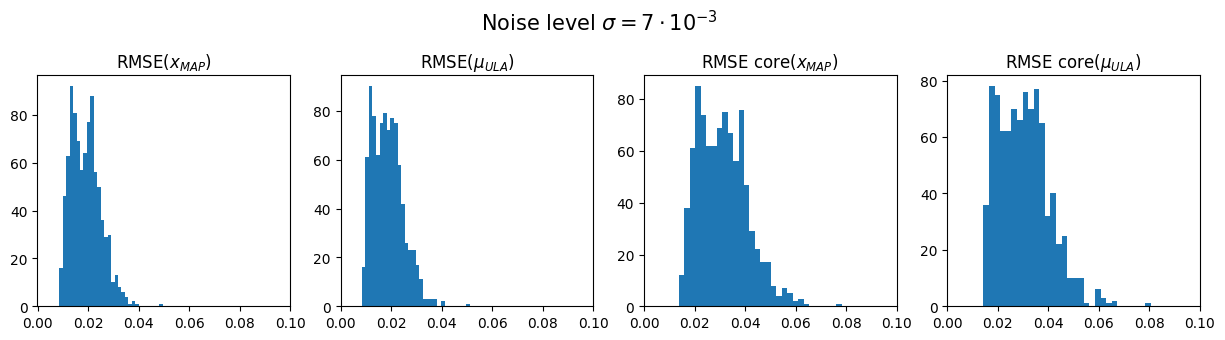

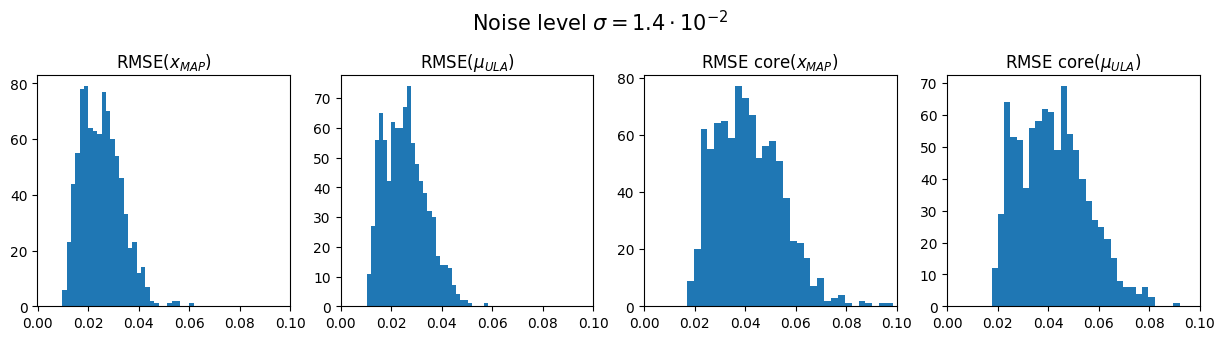

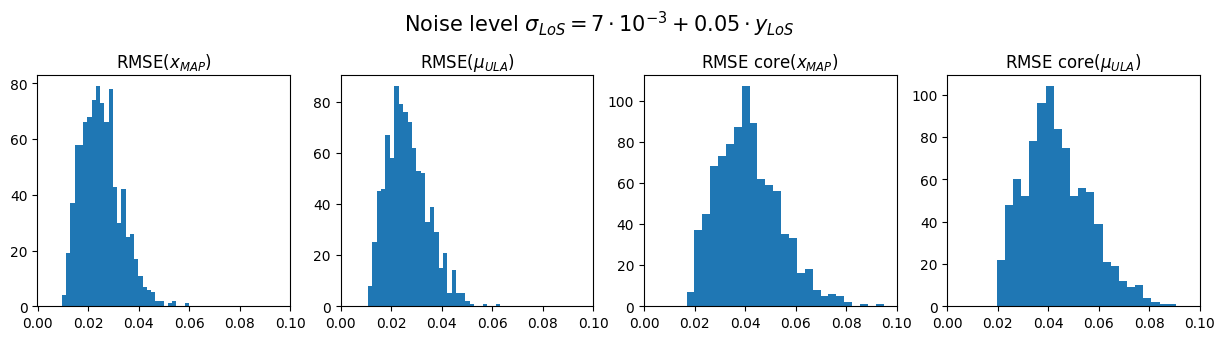

In [20]:
metrics = ["RMSE", "RMSE-core"]

for i, noise_level in enumerate(noise_levels):
    fig, ax = plt.subplots(1,4, figsize=(15,3))
    ax[0].hist(np.sqrt(aggregate_data[i]["mse_map"]), bins=30)
    ax[0].set_xlim([-1e-4,1e-1])
    ax[0].set_title(r"RMSE($x_{MAP}$)")
    ax[1].hist(np.sqrt(aggregate_data[i]["mse_mean"]), bins=30)
    ax[1].set_xlim([-1e-4,1e-1])
    ax[1].set_title(r"RMSE($\mu_{ULA}$)")
    
    ax[2].hist(np.sqrt(aggregate_data[i]["mse_map_core"]), bins=30)
    ax[2].set_xlim([-1e-4,1e-1])
    ax[2].set_title(r"RMSE core($x_{MAP}$)")
    ax[3].hist(np.sqrt(aggregate_data[i]["mse_mean_core"]), bins=30)
    ax[3].set_xlim([-1e-4,1e-1])
    ax[3].set_title(r"RMSE core($\mu_{ULA}$)")
    
    plt.suptitle("Noise level " + noise_level, y=1.1, fontsize=15)
    plt.show()

In [21]:
for i, noise_level in enumerate(noise_levels):
    print("Noise level " + noise_levels[i])
    print("Average (across phantoms) mean squared error (MAP) ",
          np.mean(aggregate_data[i]["mse_map"]), " +- ", np.std(aggregate_data[i]["mse_map"]))
    print("Average (across phantoms) mean squared error (mean) ",
          np.mean(aggregate_data[i]["mse_mean"]), " +- ", np.std(aggregate_data[i]["mse_mean"]))
    print("Average (across phantoms) mean absolute percentage error (MAP) ",
          100*np.mean(aggregate_data[i]["mape_map"]), " +- ", 100*np.std(aggregate_data[i]["mape_map"]))
    print("Average (across phantoms) mean absolute percentage error (mean) ",
          100*np.mean(aggregate_data[i]["mape_mean"]), " +- ", 100*np.std(aggregate_data[i]["mape_mean"]))
    print("Average core (across phantoms) root mean squared error (MAP) ",
          np.mean(np.sqrt(aggregate_data[i]["mse_map_core"])), " +- ", np.std(np.sqrt(aggregate_data[i]["mse_map_core"])))
    print("Average core (across phantoms) root mean squared error (mean) ",
          np.mean(np.sqrt(aggregate_data[i]["mse_mean_core"])), " +- ", np.std(np.sqrt(aggregate_data[i]["mse_mean_core"])))
    print("\n")

Noise level $\sigma=7\cdot 10^{-3}$
Average (across phantoms) mean squared error (MAP)  0.0003977206617747096  +-  0.0002513510286044221
Average (across phantoms) mean squared error (mean)  0.000380843667031099  +-  0.00025671904237561694
Average (across phantoms) mean absolute percentage error (MAP)  15.060665520574348  +-  5.8106808858288215
Average (across phantoms) mean absolute percentage error (mean)  13.74732516127416  +-  7.385529855178777
Average core (across phantoms) root mean squared error (MAP)  0.03119305126564985  +-  0.009645698132593439
Average core (across phantoms) root mean squared error (mean)  0.03037496193881467  +-  0.00989607075280263


Noise level $\sigma=1.4\cdot 10^{-2}$
Average (across phantoms) mean squared error (MAP)  0.0006961884947332018  +-  0.00044797428477698017
Average (across phantoms) mean squared error (mean)  0.0007139737630198605  +-  0.0004604504766858231
Average (across phantoms) mean absolute percentage error (MAP)  18.369682883370807  +-  

### Peak location
We analyze accuracy of estimate of emission peak location.

In [22]:
for i, noise_level in enumerate(noise_levels):
    print("Noise level " + noise_levels[i])

    print("Distance of true peak from estimated one {:.2f}".format(100*np.mean(np.linalg.norm(aggregate_data[i]["peak_distance_from_mean"], axis=1))), "cm +- {:.2f}".format(np.std(100*np.linalg.norm(aggregate_data[i]["peak_distance_from_mean"], axis=1))), "cm")
    
    print("Horizontal distance of true peak from estimated one {:.2f}".format(100*np.mean(aggregate_data[i]["peak_distance_from_mean"][:,1])), "cm +- {:.2f}".format(100*np.std(aggregate_data[i]["peak_distance_from_mean"][:,1])), "cm")
    
    print("Vertical distance of true peak from estimated one {:.2f}".format(100*np.mean(-aggregate_data[i]["peak_distance_from_mean"][:,0])), "cm +- {:.2f}".format(100*np.std(-aggregate_data[i]["peak_distance_from_mean"][:,0])), "cm")
    
    print("\n")

Noise level $\sigma=7\cdot 10^{-3}$
Distance of true peak from estimated one 4.32 cm +- 3.74 cm
Horizontal distance of true peak from estimated one -0.59 cm +- 3.40 cm
Vertical distance of true peak from estimated one -0.65 cm +- 4.51 cm


Noise level $\sigma=1.4\cdot 10^{-2}$
Distance of true peak from estimated one 5.55 cm +- 4.27 cm
Horizontal distance of true peak from estimated one -0.28 cm +- 3.82 cm
Vertical distance of true peak from estimated one -0.98 cm +- 5.79 cm


Noise level $\sigma_{LoS}=7\cdot 10^{-3} + 0.05\cdot y_{LoS}$
Distance of true peak from estimated one 6.28 cm +- 4.62 cm
Horizontal distance of true peak from estimated one -0.12 cm +- 4.36 cm
Vertical distance of true peak from estimated one -1.09 cm +- 6.37 cm




In [23]:
for i, noise_level in enumerate(noise_levels):
    print("Noise level " + noise_levels[i])
    print("Percentage of phantoms such that true peak location is within one standard deviation from estimated location ", 100*np.mean(aggregate_data[i]["peak_within_n_stds"][:,0]), "%")
    print("Percentage of phantoms such that true peak location is within two standard deviations from estimated location ", 100*np.mean(aggregate_data[i]["peak_within_n_stds"][:,1]), "%")
    print("Percentage of phantoms such that true peak location is within three standard deviations from estimated location ", 100*np.mean(aggregate_data[i]["peak_within_n_stds"][:,2]), "%")
    print("\n")

Noise level $\sigma=7\cdot 10^{-3}$
Percentage of phantoms such that true peak location is within one standard deviation from estimated location  69.66666666666667 %
Percentage of phantoms such that true peak location is within two standard deviations from estimated location  98.0 %
Percentage of phantoms such that true peak location is within three standard deviations from estimated location  100.0 %


Noise level $\sigma=1.4\cdot 10^{-2}$
Percentage of phantoms such that true peak location is within one standard deviation from estimated location  62.55555555555555 %
Percentage of phantoms such that true peak location is within two standard deviations from estimated location  97.11111111111111 %
Percentage of phantoms such that true peak location is within three standard deviations from estimated location  99.66666666666667 %


Noise level $\sigma_{LoS}=7\cdot 10^{-3} + 0.05\cdot y_{LoS}$
Percentage of phantoms such that true peak location is within one standard deviation from estimat

### Radiated power
We analyze accuracy of total radiated power estimation.

In [24]:
for i, noise_level in enumerate(noise_levels):
    print("Noise level " + noise_levels[i])
    print(r"Relative error on Prad MAP", 100*np.mean(aggregate_data[i]["prad_rel_error_map"]), "% +-", 100*np.std(aggregate_data[i]["prad_rel_error_map"]), "%")
    print(r"Relative error on Prad mean(ULA)", 100*np.mean(aggregate_data[i]["prad_rel_error_mean"]), "% +-", 100*np.std(aggregate_data[i]["prad_rel_error_mean"]), "%")
    print("\n")

Noise level $\sigma=7\cdot 10^{-3}$
Relative error on Prad MAP -0.28172879948247026 % +- 0.5759411425580864 %
Relative error on Prad mean(ULA) 0.4276600352743358 % +- 0.9730830783753949 %


Noise level $\sigma=1.4\cdot 10^{-2}$
Relative error on Prad MAP -0.5147530168888266 % +- 1.0633459660590858 %
Relative error on Prad mean(ULA) 0.9802497145486441 % +- 1.8791888483280457 %


Noise level $\sigma_{LoS}=7\cdot 10^{-3} + 0.05\cdot y_{LoS}$
Relative error on Prad MAP -1.0270368523476958 % +- 0.9072553001548609 %
Relative error on Prad mean(ULA) 0.09957721323542762 % +- 1.3589233413722903 %




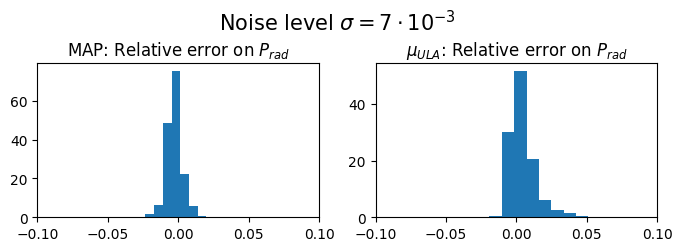

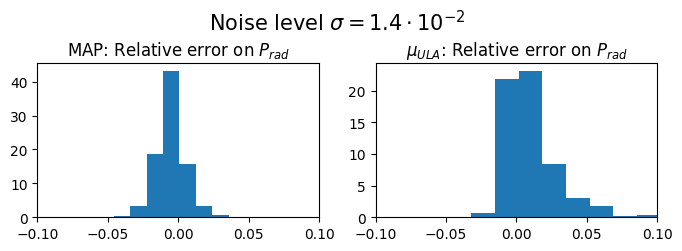

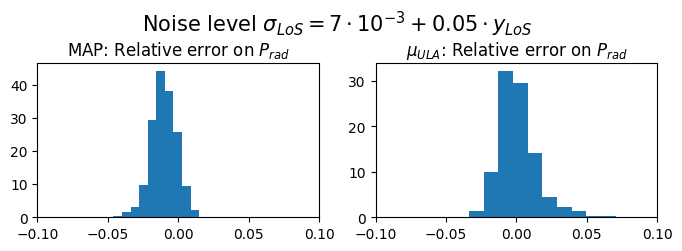

In [25]:
for i, noise_level in enumerate(noise_levels):
    fig, ax = plt.subplots(1,2, figsize=(8,2))
    ax[0].hist(aggregate_data[i]["prad_rel_error_map"], bins=10, density=True)
    ax[0].set_title(r"MAP: Relative error on $P_{rad}$")
    ax[0].set_xlim([-1e-1,1e-1])
    ax[1].hist(aggregate_data[i]["prad_rel_error_mean"], bins=10, density=True)
    ax[1].set_title(r"$\mu_{ULA}$: Relative error on $P_{rad}$")
    ax[1].set_xlim([-1e-1,1e-1])
    plt.suptitle("Noise level " + noise_level, y=1.15, fontsize=15)
    plt.show()

In [26]:
for i, noise_level in enumerate(noise_levels):
    print("Noise level " + noise_levels[i])
    print("Percentage of phantoms such that true radiated power is within one standard deviation from estimated value ", 100*np.mean(aggregate_data[i]["prad_within_n_stds"][:,0]), "%")
    print("Percentage of phantoms such that true radiated power is within two standard deviations from estimated value ", 100*np.mean(aggregate_data[i]["prad_within_n_stds"][:,1]), "%")
    print("Percentage of phantoms such that true radiated power is within three standard deviations from estimated value ", 100*np.mean(aggregate_data[i]["prad_within_n_stds"][:,2]), "%")
    print("\n")

Noise level $\sigma=7\cdot 10^{-3}$
Percentage of phantoms such that true radiated power is within one standard deviation from estimated value  56.111111111111114 %
Percentage of phantoms such that true radiated power is within two standard deviations from estimated value  85.55555555555556 %
Percentage of phantoms such that true radiated power is within three standard deviations from estimated value  96.0 %


Noise level $\sigma=1.4\cdot 10^{-2}$
Percentage of phantoms such that true radiated power is within one standard deviation from estimated value  50.888888888888886 %
Percentage of phantoms such that true radiated power is within two standard deviations from estimated value  80.77777777777779 %
Percentage of phantoms such that true radiated power is within three standard deviations from estimated value  93.66666666666667 %


Noise level $\sigma_{LoS}=7\cdot 10^{-3} + 0.05\cdot y_{LoS}$
Percentage of phantoms such that true radiated power is within one standard deviation from esti

# Phantom analysis results: plots

In [27]:
idxs=[194, 37, 41]
for idx in idxs:
    print(idx)
    print("MAPE")
    print(100*aggregate_data[1]["mse_map"][idx])
    print(100*aggregate_data[1]["mse_mean"][idx])
    print("Prad")
    print(100*aggregate_data[1]["prad_rel_error_map"][idx])
    print(100*aggregate_data[1]["prad_rel_error_mean"][idx])
    print("peak")
    print(100*np.linalg.norm(aggregate_data[1]["peak_distance_from_mean"][idx,:]))
    print("nb stds")
    print(100*aggregate_data[1]["pixels_within_n_stds"][idx, 0])
    print(100*aggregate_data[1]["pixels_within_n_stds"][idx, 1])
    
    print("\n")
    
    

194
MAPE
0.022750684445359257
0.020729803772417153
Prad
-0.9970471322481222
-0.5271225148256337
peak
1.3365271064407531
nb stds
92.99363057324841
98.38314551690348


37
MAPE
0.03654921842050207
0.036237605492574695
Prad
0.10030843530506421
0.3665337370164639
peak
3.952979512916049
nb stds
91.62621359223301
98.48300970873787


41
MAPE
0.04626359314637936
0.06364900277147274
Prad
-0.6304485411696102
-0.27994067034094666
peak
10.166505467750175
nb stds
87.53333333333333
98.26666666666667




In [28]:
# Load phantom data
psis = np.load('../dataset_generation/sxr_samples/psis.npy')
sxr_samples  = np.load('../dataset_generation/sxr_samples/sxr_samples_with_background.npy')
alphas  = np.load('../dataset_generation/sxr_samples/alpha_random_values.npy')
trim_vals = np.load('../dataset_generation/sxr_samples/trimming_values.npy')
random_peak_vals  = np.load('../dataset_generation/sxr_samples/peak_values_gaussian_background.npy')


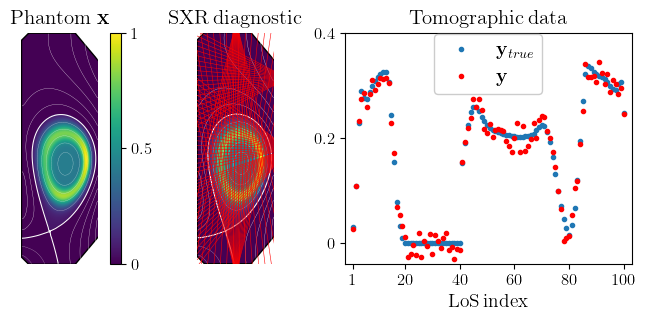

In [41]:
idx = 41

sample = sxr_samples[idx, :, :]
psi = psis[idx, :, :]

uq_data_dir = "uq_study_results/sigma01"
uq_data_idx = np.load(uq_data_dir + '/uq_data_' + str(idx) + '.npy', allow_pickle=True).item()


ground_truth=sample

fig, ax = plt.subplots(1, 3, figsize=(8, 3), width_ratios=[1, 1, 2.5])
plt.subplots_adjust(wspace=0.3)

plt.rcParams.update({
        "text.usetex": True,
        "font.family": "sans-serif",
        'text.latex.preamble': r"""\usepackage{bm}""",
    })
    

# plot ground truth
cbar_tick_params={"labelsize":12, "yticks":[0,0.5,1], "yticklabels":[r"$0$",  r"$0.5$", r"$1$"]}
tomo_plots.plot_profile(ground_truth, tcv_plot_clip=True, contour_image=psi, levels=12,
               ax=ax[0], colorbar=True, contour_color="w", cbar_tick_params=cbar_tick_params, pad_cbar=0.1)
ax[0].set_title(r"$\mathrm{Phantom}\;\mathbf{x}$", fontsize=15)

# plot ground truth, superposing the sxr LoS
tomo_plots.plot_profile(np.flip(ground_truth, axis=0), levels=12, tcv_plot_clip=True, ax=ax[1], contour_image=np.flip(psi,0))
#tomo_plots.plot_profile(np.flip(ground_truth, axis=0), levels=12, tcv_plot_clip=True, ax=ax[1])
sxr_LoS_params = np.load("../../tomo_fusion/forward_model/sxr_LoS_params.npy")
r = np.linspace(0, ground_truth.shape[0], 10)
center = np.array(ground_truth.shape, dtype=int) / 2
Lr, Lz = 0.511, 1.5
h = Lz / ground_truth.shape[0]
for i in range(sxr_LoS_params.shape[0]):
    if np.isclose(np.tan(sxr_LoS_params[i, 1]), 0, atol=1e-6):
        ax[i].vlines(center[1] + sxr_LoS_params[i, 0], 0, Lz, "r", linewidth=0.3)
    else:
        p = sxr_LoS_params[i, 0]
        theta = sxr_LoS_params[i, 1]
        y = center[0] + p / h / np.sin(theta) - (r - center[1]) / np.tan(theta)
        ax[1].plot(r, y, "r", linewidth=0.4)
ax[1].set_xlim([0, ground_truth.shape[1]])
ax[1].set_ylim([0, round(Lz / h)])
ax[1].set_title(r"$\mathrm{SXR\,diagnostic}$", fontsize=15)

# plot tomographic data
ax[2].plot(np.arange(1, 101), uq_data_idx["tomo_data"], '.', label=r"$\mathbf{y}_{true}$")
ax[2].plot(np.arange(1, 101), uq_data_idx["noisy_tomo_data"], 'r.', label=r"$\mathbf{y}$")
ax[2].set_xlabel(r"$\mathrm{LoS\,index}$", fontsize=14)
#ax[2].set_xlabel("Line of sight index", fontsize=14)
ax[2].set_xlim([-2, 103])
ax[2].tick_params(labelsize=12)
#ax[2].set_xticks([1, 50, 100])
#ax[2].set_xticklabels([r"$1$", r"$50$", r"$100$"])
ax[2].set_xticks([1, 20,40,60,80,100])
ax[2].set_xticklabels([r"$1$", r"$20$", r"$40$", r"$60$", r"$80$", r"$100$"])
ax[2].set_ylim([-0.04,0.4])
ax[2].set_yticks([0,0.2,0.4])
ax[2].set_yticklabels([r"$0$",r"$0.2$",r"$0.4$"])
#ax[2].set_ylabel(r"$y$", rotation=0, fontsize=12, labelpad=10)
ax[2].set_title(r"$\mathrm{Tomographic\,data}$", fontsize=15)
ax[2].legend(loc=(0.31,0.735), fontsize=14, framealpha=1)

#plt.savefig('../figures/diag.eps', format='eps', bbox_inches="tight")

plt.show()

In [42]:
idxs = [10]  #14, 28, 30 (quite nice), 31, 33, 37, 41(very nice), 59(large alpha), 60 (small alpha, spred out peak,, nice), 74 (small alpha, uncertain peak, nice), 113 (medium alpha, not bad), 154 (medium alpha, nice)
ph_strs = ["xA", "xB", "xC"]
ph_strs_title = [r"$\mathbf{x}_A$", r"$\mathbf{x}_B$", r"$\mathbf{x}_C$"]
ph_strs_title_small = [r"$\mathbf{x}_{_A}$", r"$\mathbf{x}_{_B}$", r"$\mathbf{x}_{_C}$"]
yticks_std_cbar = [[0,0.06,0.12], [0,0.075,0.15], [0,0.06,0.12]]
yticklabels_std_cbar = [[r"$0$", r"$0.06$", r"$0.12$"], [r"$0$", r"$0.075$", r"$0.15$"], [r"$0$", r"$0.06$", r"$0.12$"]]

[40.26318 20.75114]
18.806123624644304 22.696156375354757 35.907983530539546 44.61837646946028


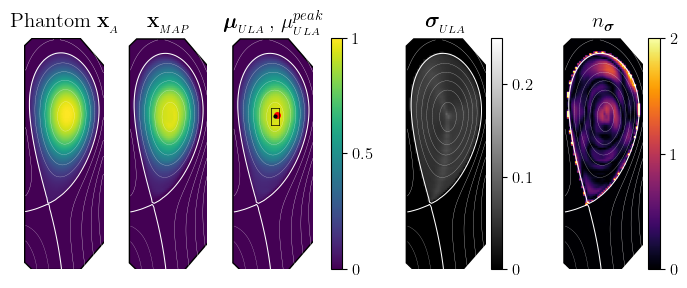

[82.92342 19.83355]
17.039641555275995 22.627458444723988 77.81134454050179 88.03549545949751


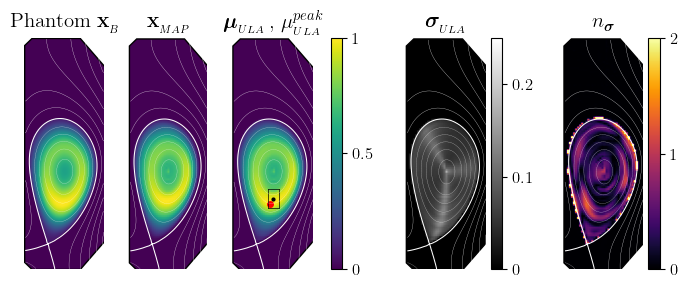

[70.4607  27.46655]
21.00148533694358 33.93161466305634 60.63029026744109 80.29110973256022


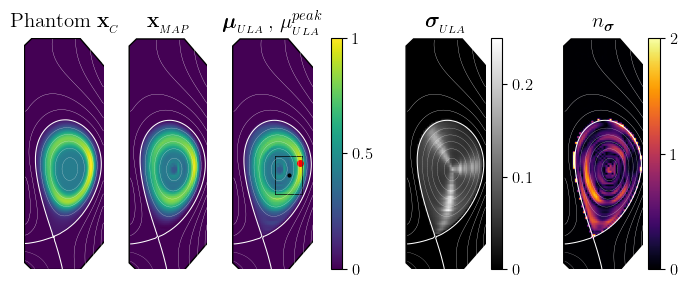

In [154]:
idxs=[194, 37, 41]
    
for i in range(3):

    idx = idxs[i]
    
    sample = sxr_samples[idx, :, :]
    psi = psis[idx, :, :]
    sample_downscaled = skimt.resize(sample, uq_data_idx["im_MAP"].shape, anti_aliasing=False, mode='edge')
    psi_downscaled = skimt.resize(psi, uq_data_idx["im_MAP"].shape, anti_aliasing=False, mode='edge')
    
    std_max = 0.25
    
    uq_data_dir = "uq_study_results/sigma01"
    uq_data_idx = np.load(uq_data_dir + '/uq_data_' + str(idx) + '.npy', allow_pickle=True).item()
    
    # create figure
    nb_subplots = 5
    fig_width = 1.65*(nb_subplots)
    width_ratios = [1]*nb_subplots
    width_ratios = [1.01, 1, 1.475, 0.1, 1.275, 0.1, 1.275]
    fig, ax = plt.subplots(1, 7, figsize=(fig_width, 3), width_ratios=width_ratios)
    plt.subplots_adjust(wspace=0.35)
    ax_counter = 0
    
    tomo_plots.plot_profile(sample, tcv_plot_clip=True, contour_image=psi,
                                 ax=ax[0], colorbar=False, contour_color="w", vmax=1, aspect="auto", levels=12)
    ax[0].set_title(r"$\mathrm{Phantom}\;$"+ph_strs_title_small[i], fontsize=15, y=1.01)
    
        
    tomo_plots.plot_profile(uq_data_idx["im_MAP"], tcv_plot_clip=True, contour_image=psi_downscaled,
                                 ax=ax[1], colorbar=False, contour_color="w", vmax=1, aspect="auto", levels=12)
    ax[1].set_title(r"$\mathbf{x}_{_{MAP}}$", fontsize=15, y=1.01)
    
    
    cbar_tick_params={"labelsize":12, "yticks":[0,0.5,1], "yticklabels":[r"$0$",  r"$0.5$", r"$1$"]}
    peak_stats = {}
    peak_stats["mean"], peak_stats["std"] = uq_data_idx["mean_peak_loc"], np.sqrt(uq_data_idx["var_peak_loc"])
    peak_stats["true_loc"], peak_stats["nb_stds"] = np.array(np.where(sample==sample.max())).reshape(2)/2, 1
    peak_stats["markersize"], peak_stats["linewidth"] = 4, 0.5
    #ax[2].autoscale(2)
    tomo_plots.plot_profile(uq_data_idx["mean"], tcv_plot_clip=True, contour_image=psi_downscaled,
                             ax=ax[2], colorbar=True, contour_color="w", vmax=1, aspect="auto", levels=12, peak_stats=peak_stats, pad_cbar=0.15, cbar_tick_params=cbar_tick_params)
    #plt.title(r"$Peak$", fontsize=15)
    #plt.title(r"$\mu_{peak}\pm\sigma_{peak}$", fontsize=15)
    ax[2].set_title(r"$\bm{\mu}_{_{ULA}}\,, \,\mu_{_{ULA}}^{peak}$", fontsize=15, y=1.01)
    
    ax[3].axis("off")
    
    
    cbar_tick_params={"labelsize":12, "yticks":[0, 0.1, 0.2], "yticklabels":[r"$0$", r"$0.1$", r"$0.2$"]}
    mask_core = tomo_helps.define_core_mask(psi=psi, dim_shape=(120,40), trim_values_x=trim_vals[idx, :])
    std = (np.sqrt(uq_data_idx["var"]))
    std *= mask_core
    tomo_plots.plot_profile(std, tcv_plot_clip=True, contour_image=psi_downscaled,
                             ax=ax[4], colorbar=True, cmap="gray", contour_color="w", vmin=0, vmax=std_max, aspect="auto", levels=12, pad_cbar=0.05, cbar_tick_params=cbar_tick_params)
    ax[4].set_title(r"$\bm{\sigma}_{_{ULA}}$", fontsize=15, y=1.01)
    
    ax[5].axis("off")
    
    cbar_tick_params={"labelsize":12, "yticks":[0,1,2], "yticklabels":[r"$0$",  r"$1$", r"$2$"]}
    nb_stds = np.abs(uq_data_idx["mean"] - sample_downscaled) / np.sqrt(uq_data_idx["var"])
    #nb_stds *= mask_core
    tomo_plots.plot_profile(nb_stds, tcv_plot_clip=True, contour_image=psi_downscaled,
                             ax=ax[6], colorbar=True, cmap="inferno", contour_color="w", vmax=2, aspect="auto", levels=12, pad_cbar=0.05, cbar_tick_params=cbar_tick_params)
    #ax[6].set_title(r"$\vert \bm{\mu}_{_{ULA}} \!- $"+ph_strs_title_small[i]+r"$\vert\,/\bm{\sigma}_{_{ULA}}$", fontsize=15, y=1.01)
    #ax[4].set_title(r"$n_{\bm{\sigma}_{_{ULA}}}$", fontsize=15, y=1.01)
    ax[6].set_title(r"$n_{\bm{\sigma}}$", fontsize=15, y=1.01)
    
    #plt.savefig('../figures/results'+ph_strs[i]+'.eps', format='eps', bbox_inches="tight")
    
    plt.show()

In [44]:
idxs=[194, 37, 41]
for idx in idxs:
    print(idx)
    print("RMSE")
    print(np.sqrt(aggregate_data[1]["mse_map"][idx]))
    print(np.sqrt(aggregate_data[1]["mse_mean"][idx]))
    print("RMSE core")
    print(np.sqrt(aggregate_data[1]["mse_map_core"][idx]))
    print(np.sqrt(aggregate_data[1]["mse_mean_core"][idx]))
    print("Prad")
    print(100*aggregate_data[1]["prad_rel_error_map"][idx])
    print(100*aggregate_data[1]["prad_rel_error_mean"][idx])
    print("peak")
    print(100*np.linalg.norm(aggregate_data[1]["peak_distance_from_mean"][idx,:]))
    print("nb stds")
    print(100*aggregate_data[1]["pixels_within_n_stds"][idx, 0])
    print(100*aggregate_data[1]["pixels_within_n_stds"][idx, 1])
    
    print("\n")
    
    

194
RMSE
0.015083330018719095
0.014397848371342557
RMSE core
0.02296764215689174
0.021904783212003464
Prad
-0.9970471322481222
-0.5271225148256337
peak
1.3365271064407531
nb stds
92.99363057324841
98.38314551690348


37
RMSE
0.01911784988446715
0.019036177529266396
RMSE core
0.032669505582826136
0.03255602455803791
Prad
0.10030843530506421
0.3665337370164639
peak
3.952979512916049
nb stds
91.62621359223301
98.48300970873787


41
RMSE
0.021508973277769294
0.02522875398656714
RMSE core
0.0389121673765273
0.04575071418688371
Prad
-0.6304485411696102
-0.27994067034094666
peak
10.166505467750175
nb stds
87.53333333333333
98.26666666666667




In [45]:
# idxs = [41, 33, 37]
# idxs=[60]
# idxs=[194, 37, 41]
# 
# std_maxs = np.zeros(3)
# for i in range(3):
#     uq_data_dir = "uq_study_results/sigma01"
#     uq_data_idx = np.load(uq_data_dir + '/uq_data_' + str(idx) + '.npy', allow_pickle=True).item()
#     std_maxs[i] = np.max(np.sqrt(uq_data_idx["var"]))
# std_max=np.max(std_maxs)
# 
# for i in range(3):
# 
#     idx = idxs[i]
# 
#     sample = sxr_samples[idx, :, :]
#     psi = psis[idx, :, :]
#     
#     sample_downscaled = skimt.resize(sample, uq_data_idx["im_MAP"].shape, anti_aliasing=False, mode='edge')
#     psi_downscaled = skimt.resize(psi, uq_data_idx["im_MAP"].shape, anti_aliasing=False, mode='edge')
#     
#     uq_data_dir = "uq_study_results/sigma01"
#     uq_data_idx = np.load(uq_data_dir + '/uq_data_' + str(idx) + '.npy', allow_pickle=True).item()
#     
#     plt.rcParams.update({
#         "text.usetex": True,
#         "font.family": "sans-serif",
#         'text.latex.preamble': r"""\usepackage{bm}""",
#     })
#     
#         
#     tomo_plots.plot_profile(sample, tcv_plot_clip=True, contour_image=psi,
#                              ax=None, colorbar=False, contour_color="w", vmax=1, aspect=None, levels=12)
#     #plt.title(r"$\mathrm{Phantom}\;\mathbf{x}_A$", fontsize=15)
#     plt.title(r"$\mathrm{Phantom}\;$"+ph_strs_title[i], fontsize=15, y=1.01)
#     plt.savefig('../figures/uq_study_results/results_phantom_'+ph_strs[i]+'.eps', format='eps', bbox_inches="tight")
#     plt.show()
#     
#     tomo_plots.plot_profile(uq_data_idx["im_MAP"], tcv_plot_clip=True, contour_image=psi_downscaled,
#                              ax=None, colorbar=False, contour_color="w", vmax=1, aspect=None, levels=12)
#     plt.title(r"$\mathbf{x}_{MAP}$", fontsize=15, y=1.01)
#     plt.savefig('../figures/uq_study_results/results_map_'+ph_strs[i]+'.eps', format='eps', bbox_inches="tight")
#     plt.show()
#     
#     tomo_plots.plot_profile(uq_data_idx["mean"], tcv_plot_clip=True, contour_image=psi_downscaled,
#                              ax=None, colorbar=False, contour_color="w", vmax=1, aspect=None, levels=12)
#     plt.title(r"$\bm{\mu}_{ULA}$", fontsize=15, y=1.01)
#     plt.savefig('../figures/uq_study_results/results_mean_'+ph_strs[i]+'.eps', format='eps', bbox_inches="tight")
#     plt.show()
#     
#     mask_core = tomo_helps.define_core_mask(psi=psi, dim_shape=(120,40), trim_values_x=trim_vals[idx, :])
#     std = (np.sqrt(uq_data_idx["var"]))
#     std *= mask_core
#     tomo_plots.plot_profile(std, tcv_plot_clip=True, contour_image=psi_downscaled,
#                              ax=None, colorbar=False, cmap="gray", contour_color="w", vmin=0, vmax=std_max, aspect=None, levels=12)
#     plt.title(r"$\bm{\sigma}_{ULA}$", fontsize=15, y=1.01)
#     plt.savefig('../figures/uq_study_results/results_std_'+ph_strs[i]+'.eps', format='eps', bbox_inches="tight")
#     plt.show()
#     
#     nb_stds = np.abs(uq_data_idx["mean"] - sample_downscaled) / np.sqrt(uq_data_idx["var"])
#     #nb_stds *= mask_core
#     tomo_plots.plot_profile(nb_stds, tcv_plot_clip=True, contour_image=psi_downscaled,
#                              ax=None, colorbar=False, cmap="inferno", contour_color="w", vmax=2, aspect=None, levels=12)
#     plt.title(r"$\vert \bm{\mu}_{_{ULA}} \!- $"+ph_strs_title_small[i]+r"$\!\vert\,/\bm{\sigma}_{_{ULA}}$", fontsize=15, y=1.01)
#     plt.savefig('../figures/uq_study_results/results_nb_stds_'+ph_strs[i]+'.eps', format='eps', bbox_inches="tight")
#     plt.show()
#     
#     
#     peak_stats = {}
#     peak_stats["mean"], peak_stats["std"] = uq_data_idx["mean_peak_loc"], np.sqrt(uq_data_idx["var_peak_loc"])
#     peak_stats["true_loc"], peak_stats["nb_stds"] = np.array(np.where(sample==sample.max())).reshape(2)/2, 1
#     peak_stats["markersize"], peak_stats["linewidth"] = 4, 0.5
#     tomo_plots.plot_profile(uq_data_idx["mean"], tcv_plot_clip=True, contour_image=psi_downscaled,
#                              ax=None, colorbar=False, contour_color="w", vmax=1, aspect=None, levels=12, peak_stats=peak_stats)
#     #plt.title(r"$Peak$", fontsize=15)
#     #plt.title(r"$\mu_{peak}\pm\sigma_{peak}$", fontsize=15)
#     plt.title(r"$\mu_{_{ULA}}^{peak}\pm\sigma_{_{ULA}}^{peak}$", fontsize=15, y=1.01)
#     plt.savefig('../figures/uq_study_results/results_peak_'+ph_strs[i]+'.eps', format='eps', bbox_inches="tight")
#     plt.show()
#     
#     
#     #r=plt.imshow(gaussian_profile)
#     plt.figure(figsize=(2,3))
#     r=plt.imshow(sxr_samples[idx,:,:], cmap="gray", vmax=np.max(np.sqrt(uq_data_idx["var"])))
#     plt.gca().set_visible(False)
#     cbar=plt.colorbar(r, aspect=20)
#     cbar.ax.tick_params(labelsize=12)
#     # cbar.ax.set_yticks(yticks_std_cbar[i])
#     # cbar.ax.set_yticklabels(yticklabels_std_cbar[i])
#     cbar.ax.set_yticks([0,0.12,0.24])
#     cbar.ax.set_yticklabels([r"$0$", r"$0.12$", r"$0.24$"])
#     plt.axis("off")
#     plt.savefig('../figures/uq_study_results/results_cbar_gray.eps', format='eps', bbox_inches="tight")
#     plt.show()
#     
#     #r=plt.imshow(gaussian_profile)
#     plt.figure(figsize=(2,3))
#     r=plt.imshow(sxr_samples[idx,:,:], cmap="inferno", vmax=2)
#     plt.gca().set_visible(False)
#     cbar=plt.colorbar(r, aspect=20)
#     cbar.ax.tick_params(labelsize=12)
#     plt.axis("off")
#     plt.savefig('../figures/uq_study_results/results_cbar_inferno.eps', format='eps', bbox_inches="tight")
#     plt.show()
#     
#     
#     #r=plt.imshow(gaussian_profile)
#     plt.figure(figsize=(2,3))
#     r=plt.imshow(sxr_samples[idx,:,:])
#     plt.gca().set_visible(False)
#     cbar=plt.colorbar(r, aspect=20)
#     cbar.ax.tick_params(labelsize=12)
#     plt.axis("off")
#     plt.savefig('../figures/phantom_generation_cbar.eps', format='eps', bbox_inches="tight")
#     plt.show()

In [46]:
# idxs = [41, 33, 37]
# idxs=[60]
# idxs=[194, 37, 41]
# 
# std_maxs = np.zeros(3)
# for i in range(3):
#     uq_data_dir = "uq_study_results/sigma01"
#     uq_data_idx = np.load(uq_data_dir + '/uq_data_' + str(idx) + '.npy', allow_pickle=True).item()
#     std_maxs[i] = np.max(np.sqrt(uq_data_idx["var"]))
# std_max=np.max(std_maxs)
# 
# for i in range(3):
# 
#     idx = idxs[i]
# 
#     sample = sxr_samples[idx, :, :]
#     psi = psis[idx, :, :]
#     
#     sample_downscaled = skimt.resize(sample, uq_data_idx["im_MAP"].shape, anti_aliasing=False, mode='edge')
#     psi_downscaled = skimt.resize(psi, uq_data_idx["im_MAP"].shape, anti_aliasing=False, mode='edge')
#     
#     uq_data_dir = "uq_study_results/sigma01"
#     uq_data_idx = np.load(uq_data_dir + '/uq_data_' + str(idx) + '.npy', allow_pickle=True).item()
#     
#     plt.rcParams.update({
#         "text.usetex": True,
#         "font.family": "sans-serif",
#         'text.latex.preamble': r"""\usepackage{bm}""",
#     })
#     
#         
#     tomo_plots.plot_profile(sample, tcv_plot_clip=True, contour_image=psi,
#                              ax=None, colorbar=False, contour_color="w", vmax=1, aspect=None, levels=12)
#     #plt.title(r"$\mathrm{Phantom}\;\mathbf{x}_A$", fontsize=15)
#     plt.title(r"$\mathrm{Phantom}\;$"+ph_strs_title_small[i], fontsize=15, y=1.01)
#     plt.savefig('../figures/uq_study_results/results_phantom_'+ph_strs[i]+'.eps', format='eps', bbox_inches="tight")
#     plt.show()
#     
#     tomo_plots.plot_profile(uq_data_idx["im_MAP"], tcv_plot_clip=True, contour_image=psi_downscaled,
#                              ax=None, colorbar=False, contour_color="w", vmax=1, aspect=None, levels=12)
#     plt.title(r"$\mathbf{x}_{_{MAP}}$", fontsize=15, y=1.01)
#     plt.savefig('../figures/uq_study_results/results_map_'+ph_strs[i]+'.eps', format='eps', bbox_inches="tight")
#     plt.show()
#     
#     # tomo_plots.plot_profile(uq_data_idx["mean"], tcv_plot_clip=True, contour_image=psi_downscaled,
#     #                          ax=None, colorbar=False, contour_color="w", vmax=1, aspect=None, levels=12)
#     # plt.title(r"$\bm{\mu}_{ULA}$", fontsize=15, y=1.01)
#     # plt.savefig('../figures/uq_study_results/results_mean_'+ph_strs[i]+'.eps', format='eps', bbox_inches="tight")
#     # plt.show()
#     
#     mask_core = tomo_helps.define_core_mask(psi=psi, dim_shape=(120,40), trim_values_x=trim_vals[idx, :])
#     std = (np.sqrt(uq_data_idx["var"]))
#     std *= mask_core
#     tomo_plots.plot_profile(std, tcv_plot_clip=True, contour_image=psi_downscaled,
#                              ax=None, colorbar=False, cmap="gray", contour_color="w", vmin=0, vmax=std_max, aspect=None, levels=12)
#     plt.title(r"$\bm{\sigma}_{_{ULA}}$", fontsize=15, y=1.01)
#     plt.savefig('../figures/uq_study_results/results_std_'+ph_strs[i]+'.eps', format='eps', bbox_inches="tight")
#     plt.show()
#     
#     nb_stds = np.abs(uq_data_idx["mean"] - sample_downscaled) / np.sqrt(uq_data_idx["var"])
#     #nb_stds *= mask_core
#     tomo_plots.plot_profile(nb_stds, tcv_plot_clip=True, contour_image=psi_downscaled,
#                              ax=None, colorbar=False, cmap="inferno", contour_color="w", vmax=2, aspect=None, levels=12)
#     plt.title(r"$\vert \bm{\mu}_{_{ULA}} \!- $"+ph_strs_title_small[i]+r"$\vert\,/\bm{\sigma}_{_{ULA}}$", fontsize=15, y=1.01)
#     plt.savefig('../figures/uq_study_results/results_nb_stds_'+ph_strs[i]+'.eps', format='eps', bbox_inches="tight")
#     plt.show()
#     
#     
#     peak_stats = {}
#     peak_stats["mean"], peak_stats["std"] = uq_data_idx["mean_peak_loc"], np.sqrt(uq_data_idx["var_peak_loc"])
#     peak_stats["true_loc"], peak_stats["nb_stds"] = np.array(np.where(sample==sample.max())).reshape(2)/2, 1
#     peak_stats["markersize"], peak_stats["linewidth"] = 4, 0.5
#     tomo_plots.plot_profile(uq_data_idx["mean"], tcv_plot_clip=True, contour_image=psi_downscaled,
#                              ax=None, colorbar=False, contour_color="w", vmax=1, aspect=None, levels=12, peak_stats=peak_stats)
#     #plt.title(r"$Peak$", fontsize=15)
#     #plt.title(r"$\mu_{peak}\pm\sigma_{peak}$", fontsize=15)
#     plt.title(r"$\bm{\mu}_{_{ULA}}\,, \,\mu_{_{ULA}}^{peak}$", fontsize=15, y=1.01)
#     plt.savefig('../figures/uq_study_results/results_mean_peak_'+ph_strs[i]+'.eps', format='eps', bbox_inches="tight")
#     plt.show()
#     
#     
#     #r=plt.imshow(gaussian_profile)
#     plt.figure(figsize=(2,3))
#     r=plt.imshow(sxr_samples[idx,:,:], cmap="gray", vmax=np.max(np.sqrt(uq_data_idx["var"])))
#     plt.gca().set_visible(False)
#     cbar=plt.colorbar(r, aspect=20)
#     cbar.ax.tick_params(labelsize=12)
#     # cbar.ax.set_yticks(yticks_std_cbar[i])
#     # cbar.ax.set_yticklabels(yticklabels_std_cbar[i])
#     cbar.ax.set_yticks([0,0.12,0.24])
#     cbar.ax.set_yticklabels([r"$0$", r"$0.12$", r"$0.24$"])
#     plt.axis("off")
#     plt.savefig('../figures/uq_study_results/results_cbar_gray.eps', format='eps', bbox_inches="tight")
#     plt.show()
#     
#     #r=plt.imshow(gaussian_profile)
#     plt.figure(figsize=(2,3))
#     r=plt.imshow(sxr_samples[idx,:,:], cmap="inferno", vmax=2)
#     plt.gca().set_visible(False)
#     cbar=plt.colorbar(r, aspect=20)
#     cbar.ax.tick_params(labelsize=12)
#     plt.axis("off")
#     plt.savefig('../figures/uq_study_results/results_cbar_inferno.eps', format='eps', bbox_inches="tight")
#     plt.show()
#     
#     
#     #r=plt.imshow(gaussian_profile)
#     plt.figure(figsize=(2,3))
#     r=plt.imshow(sxr_samples[idx,:,:])
#     plt.gca().set_visible(False)
#     cbar=plt.colorbar(r, aspect=20)
#     cbar.ax.tick_params(labelsize=12)
#     plt.axis("off")
#     plt.savefig('../figures/phantom_generation_cbar.eps', format='eps', bbox_inches="tight")
#     plt.show()

In [47]:
# from src.tomo_fusion.tools import plotting_fcts as tomo_plots
# 
# for i in range(3):
# 
#     idx = idxs[i]
# 
#     sample = sxr_samples[idx, :, :]
#     psi = psis[idx, :, :]
#     
#     sample_downscaled = skimt.resize(sample, uq_data_idx["im_MAP"].shape, anti_aliasing=False, mode='edge')
#     psi_downscaled = skimt.resize(psi, uq_data_idx["im_MAP"].shape, anti_aliasing=False, mode='edge')
#     
#     uq_data_dir = "uq_study_results/sigma01"
#     uq_data_idx = np.load(uq_data_dir + '/uq_data_' + str(idx) + '.npy', allow_pickle=True).item()
#     
#     plt.rcParams.update({
#         "text.usetex": True,
#         "font.family": "sans-serif",
#         'text.latex.preamble': r"""\usepackage{bm}""",
#     })
#     
#     peak_stats = {}
#     peak_stats["mean"], peak_stats["std"] = uq_data_idx["mean_peak_loc"], np.sqrt(uq_data_idx["var_peak_loc"])
#     peak_stats["true_loc"], peak_stats["nb_stds"] = np.array(np.where(sample==sample.max())).reshape(2)/2, 1
#     peak_stats["markersize"], peak_stats["linewidth"] = 4, 0.5
#     tomo_plots.plot_profile(uq_data_idx["mean"], tcv_plot_clip=True, contour_image=psi_downscaled,
#                              ax=None, colorbar=False, contour_color="w", vmax=1, aspect=None, levels=12, peak_stats=peak_stats)
#     #plt.title(r"$Peak$", fontsize=15)
#     #plt.title(r"$\mu_{peak}\pm\sigma_{peak}$", fontsize=15)
#     plt.title(r"$\bm{\mu}_{_{ULA}}\,, \,\mu_{_{ULA}}^{peak}$", fontsize=15, y=1.01)
#     #plt.savefig('../figures/uq_study_results/results_mean_peak_'+ph_strs[i]+'.eps', format='eps', bbox_inches="tight")
#     plt.show()